<a href="https://colab.research.google.com/github/dmitriygorlov/DS-practice/blob/main/NLP_wine_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описания задачи

Суть: узнать стоимость вина из рассказа сомелье

Подробнее: вам подарили вино и расказали о нём со слов сомелье. Вы хотит понять насколько быть обрадованы подарку. Нужен сервис, куда вы сможете загрузить описание и оно выдаст стоимость вина.

Оптимизировать будем по MSE - метрика больше штрафует за сильные отклонения (нам важно не принять дешевое вино за дорогое и наоборот, а вот ошибка в пару долларов нам не существенна)

**ВАЖНО: ЦЕНА ВИНА НАТРЕНИРОВАНА ИМЕННО НА ДАННОМ ДАТАСЕТЕ**

P.S. также в некоторых моделях нехваает максимального кол-ва итераций, но увеличивать на таком разнообразии было слишком долго

# План исследования

- Загрузка данных
- Построение моделей с помощью TF-IDF
  - Простые модели
  - Модели с подобраннми гиперпараметрами
- Построение моделей с помощью TF-IDF (с предварительной лемматизацией)
  - Простые модели
  - Модели с подобраннми гиперпараметрами
- Вывод

In [1]:
# math and dataframe
import pandas as pd
import numpy as np

# деление, кросс, тюнинг
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# для TF-idf
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer

# для лемматизации
import re
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Модели и метрики
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


rnd = 12345

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Загрузка и предобработка данных

Возьмём данные из прекрасного датасета [Wine reviews](https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data_first150k.csv). Для простоты скопировал данные на Drive

https://drive.google.com/file/d/1uGSYndd57lPLebTts3mXJzzvG3rK08kq/view?usp=sharing

In [2]:
! gdown --id 1uGSYndd57lPLebTts3mXJzzvG3rK08kq

Downloading...
From: https://drive.google.com/uc?id=1uGSYndd57lPLebTts3mXJzzvG3rK08kq
To: /content/winemag-data_first150k.csv.zip
100% 17.5M/17.5M [00:00<00:00, 65.9MB/s]


In [3]:
!unzip '/content/winemag-data_first150k.csv.zip' -d '/content/wine/'

Archive:  /content/winemag-data_first150k.csv.zip
  inflating: /content/wine/winemag-data_first150k.csv  


In [4]:
data = pd.read_csv('/content/wine/winemag-data_first150k.csv', index_col=0)

display(data.head())
data.info()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB


Итак, у нас есть 150930 строк со следующими столбцами:
- 'country' (страна), 
- 'description' (описание) - это наш источник информации. Пропусков нет., 
- 'designation' (обозначение виноградника), 
- 'points' (баллы),
- 'price' (цена) - это наш целевой показатель. Есть много пропусков, 
- 'province' (провинция),
- 'region_1' (регион), 
- 'region_2' (регион уточнение), 
- 'variety' (тип винограда),  
- 'winery' (винодельня).

In [5]:
df = data[['description', 'price']].dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137235 entries, 0 to 150929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  137235 non-null  object 
 1   price        137235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


In [6]:
mini_df = df.sample(20000)
mini_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 120166 to 124016
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  20000 non-null  object 
 1   price        20000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 468.8+ KB


In [7]:
mini_df.price.describe()

count    20000.00000
mean        33.09025
std         39.27542
min          4.00000
25%         16.00000
50%         24.00000
75%         40.00000
max       2300.00000
Name: price, dtype: float64

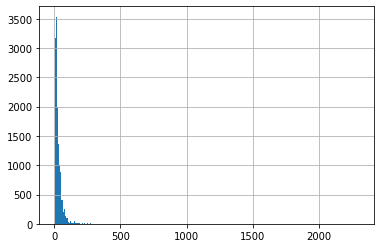

In [8]:
bins = int((mini_df.price.max() - mini_df.price.min())/5)
mini_df.price.hist(bins= bins)

Как мы видим, в наборе данных есть как очень дорогие ценники (выбросы), так и небольшие. только четверть вина стоит больше 40 долларов.

In [9]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clear_lemm_text_word(text):
    filtro = re.sub(r'[^a-zA-Z]', ' ', str(text))
    splito = filtro.split()
    # clearo = ' '.join(splito)
    lemm_list = list()
    for w in nltk.word_tokenize(' '.join(splito)):
        lemmm_uno = lemmatizer.lemmatize(w, get_wordnet_pos(w))
        lemm_list.append(lemmm_uno)
    lemm_text = ' '.join(lemm_list)
    return lemm_text

In [10]:
mini_df['description_lemm'] = mini_df['description'].apply(clear_lemm_text_word)

In [11]:
train, test = train_test_split(mini_df, test_size = 0.25, random_state = rnd)

# Простой TF-IDF

In [12]:
X_train = train['description']
X_test = test['description']
y_train = train['price']
y_test = test['price']

In [13]:
count_tf_idf1 = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)) 

tf_idf_train = count_tf_idf1.fit_transform(X_train)
tf_idf_test = count_tf_idf1.transform(X_test)

print('Размер train:', tf_idf_train.shape)
print('Размер test:', tf_idf_test.shape)

Размер train: (15000, 192182)
Размер test: (5000, 192182)


## Просто модели

In [14]:
simple_results = pd.DataFrame(columns=['Train_r2', 'Test_r2', 'Test_MSE', 'Test_MAE'])
models = {}
def simple_model(model_name, model, cv = 4, score = 'r2', back = False, show=True, lemm=False,
                 X_train = tf_idf_train, y_train = y_train, X_test = tf_idf_test, y_test = y_test):
  print(model_name, '\n')
  model.fit(X_train, y_train)

  train_score = cross_val_score(model, 
                        X_train, 
                        y_train, 
                        cv=cv,
                        scoring=score).mean().round(3)
  if show==True:
    print(f'Model params: \n{model}')
    print(f'Train_cv {score}: {train_score}')

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred).round(3)
    mae = mean_absolute_error(y_test, y_pred).round(1)
    mse = mean_squared_error(y_test, y_pred).round(1)
    print('Test results',
        f'R2 score: {r2} \nMSE: {mse} \nMAE: {mae}', sep = '\n')
    simple_results.loc[model_name] = [train_score, r2, mse, mae]
  if lemm == True:
    models['lemm+tf-idf' + 'simple' + model_name] = model
  else:
    models['tf-idf', 'simple', model_name] = model
  if back == True:
    return model

In [15]:
simple_model('LinearRegression', LinearRegression(n_jobs=-1))

LinearRegression 

Model params: 
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
Train_cv r2: 0.176
Test results
R2 score: 0.179 
MSE: 1224.3 
MAE: 17.2


In [16]:
simple_model('Lasso', Lasso(random_state=rnd))

Lasso 

Model params: 
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=12345,
      selection='cyclic', tol=0.0001, warm_start=False)
Train_cv r2: -0.001
Test results
R2 score: -0.0 
MSE: 1490.7 
MAE: 19.2


In [17]:
simple_model('Ridge', Ridge(random_state=rnd))

Ridge 

Model params: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=12345, solver='auto', tol=0.001)
Train_cv r2: 0.2
Test results
R2 score: 0.245 
MSE: 1124.9 
MAE: 15.5


In [18]:
simple_model('SGDRegressor', SGDRegressor(random_state=rnd))

SGDRegressor 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Model params: 
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12345,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Train_cv r2: 0.178
Test results
R2 score: 0.224 
MSE: 1156.1 
MAE: 15.4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [19]:
simple_model('LGBMRegressor', LGBMRegressor(random_state=rnd))

LGBMRegressor 

Model params: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Train_cv r2: 0.168
Test results
R2 score: 0.207 
MSE: 1182.2 
MAE: 15.2


### Результаты моделей без оптимизации

In [20]:
display(simple_results)

,Train_r2,Test_r2,Test_MSE,Test_MAE
LinearRegression,0.176,0.179,1224.3,17.2
Lasso,-0.001,-0.000,1490.7,19.2
Ridge,0.200,0.245,1124.9,15.5
SGDRegressor,0.178,0.224,1156.1,15.4
LGBMRegressor,0.168,0.207,1182.2,15.2


## Random_search

In [21]:
search_results = pd.DataFrame(columns=['Test_r2', 'Test_MSE', 'Test_MAE'])

def rand(model_name, model, params, early = False, iter = 10, scoring = 'neg_mean_squared_error', cv = 5, back = False, show = True, lemm = False, 
         X_train = tf_idf_train, y_train = y_train, X_test = tf_idf_test, y_test = y_test):
  print(model_name, '\n')
  clf = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = iter, cv = cv, scoring = scoring, n_jobs = -1, random_state=rnd)
  if early == True:
    fit_params={'early_stopping_rounds':20, 'eval_metric' : scoring, 'eval_set' : [[X_test, y_test]]}
    clf.fit(X_train, y_train, fit_params=fit_params)
  else:
    clf.fit(X_train, y_train)
  if show==True:  
    print('Parametrs of best Model', clf.best_estimator_)
    best = clf.best_estimator_
    y_pred = best.predict(X_test)
    
    r2 = r2_score(y_test, y_pred).round(3)
    mae = mean_absolute_error(y_test, y_pred).round(1)
    mse = mean_squared_error(y_test, y_pred).round(1)
    print('Test results',
        f'R2 score: {r2} \nMSE: {mse} \nMAE: {mae}', sep = '\n')
    
    search_results.loc[model_name] = [r2, mse, mae]
  if lemm == True:
    models['lemm+tf-idf' + 'tuned' + model_name] = model
  else:
    models['tf-idf' + 'simple' + model_name] = model
  if back == True:
    return best

In [22]:
# Lasso(random_state=rnd).get_params()
name_las = 'Lasso'
model_las = Lasso(random_state=rnd)
params_las = {
    'alpha': list(np.arange(0.001, 1, 0.005)),
    'selection': ['cyclic', 'random']
}

In [23]:
rand(name_las, model_las, params_las)

Lasso 

Parametrs of best Model Lasso(alpha=0.9460000000000001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=12345,
      selection='cyclic', tol=0.0001, warm_start=False)
Test results
R2 score: -0.0 
MSE: 1490.7 
MAE: 19.2


In [24]:
name_ridge = 'Ridge'
model_ridge = Ridge(random_state=rnd)
params_ridge = {
    'alpha': list(np.arange(0.001, 1, 0.005))
    # 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

In [25]:
rand(name_ridge, model_ridge, params_ridge)

Ridge 

Parametrs of best Model Ridge(alpha=0.676, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=12345, solver='auto', tol=0.001)
Test results
R2 score: 0.241 
MSE: 1130.7 
MAE: 15.8


In [26]:
name_sgd = 'SGDRegressor'
model_sgd = SGDRegressor(random_state=rnd)
params_sgd = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': list(np.arange(0.00001, 0.1, 0.00005))
}

In [27]:
rand(name_sgd, model_sgd, params_sgd)

SGDRegressor 

Parametrs of best Model SGDRegressor(alpha=0.01206, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_epsilon_insensitive',
             max_iter=1000, n_iter_no_change=5, penalty='elasticnet',
             power_t=0.25, random_state=12345, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Test results
R2 score: 0.061 
MSE: 1399.3 
MAE: 17.8


In [28]:
name_lgbm = 'LGBMRegressor'
model_lgbm = LGBMRegressor(random_state = rnd)
params_lgbm = {
    'n_estimators' : list(range(100, 1001, 450)),
    'depth' : [30, 15, 10, 5],
    'learning_rate' : list(np.arange(0.001, 1, 0.005))
}

In [29]:
rand(name_lgbm, model_lgbm, params_lgbm, early = 'True')

LGBMRegressor 

Parametrs of best Model LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=10, importance_type='split', learning_rate=0.331,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
Test results
R2 score: 0.171 
MSE: 1236.0 
MAE: 16.0


### Результаты моделей после radom_search

In [30]:
display(search_results)

,Test_r2,Test_MSE,Test_MAE
Lasso,-0.000,1490.7,19.2
Ridge,0.241,1130.7,15.8
SGDRegressor,0.061,1399.3,17.8
LGBMRegressor,0.171,1236.0,16.0


In [31]:
fin_tf = pd.concat([simple_results, search_results], keys=['simple', 'tuned'])

# lemm + tf-idf

In [32]:
X_train = train['description_lemm']
X_test = test['description_lemm']
y_train = train['price']
y_test = test['price']

In [33]:
count_tf_idf2 = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2)) 

tf_idf_train = count_tf_idf2.fit_transform(X_train)
tf_idf_test = count_tf_idf2.transform(X_test)

print('Размер train:', tf_idf_train.shape)
print('Размер test:', tf_idf_test.shape)

Размер train: (15000, 175194)
Размер test: (5000, 175194)


## Просто модели

In [34]:
simple_model('LinearRegression', LinearRegression(n_jobs=-1), lemm = True)

LinearRegression 

Model params: 
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)
Train_cv r2: 0.176
Test results
R2 score: 0.179 
MSE: 1224.3 
MAE: 17.2


In [35]:
simple_model('Lasso', Lasso(random_state=rnd), lemm = True)

Lasso 

Model params: 
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=12345,
      selection='cyclic', tol=0.0001, warm_start=False)
Train_cv r2: -0.001
Test results
R2 score: -0.0 
MSE: 1490.7 
MAE: 19.2


In [36]:
simple_model('Ridge', Ridge(random_state=rnd), lemm = True)

Ridge 

Model params: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=12345, solver='auto', tol=0.001)
Train_cv r2: 0.2
Test results
R2 score: 0.245 
MSE: 1124.9 
MAE: 15.5


In [37]:
simple_model('SGDRegressor', SGDRegressor(random_state=rnd), lemm = True)

SGDRegressor 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Model params: 
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12345,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Train_cv r2: 0.178
Test results
R2 score: 0.224 
MSE: 1156.1 
MAE: 15.4


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [38]:
simple_model('LGBMRegressor', LGBMRegressor(random_state=rnd), lemm = True)

LGBMRegressor 

Model params: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Train_cv r2: 0.168
Test results
R2 score: 0.207 
MSE: 1182.2 
MAE: 15.2


### Результаты моделей без оптимизации

In [39]:
display(simple_results)

,Train_r2,Test_r2,Test_MSE,Test_MAE
LinearRegression,0.176,0.179,1224.3,17.2
Lasso,-0.001,-0.000,1490.7,19.2
Ridge,0.200,0.245,1124.9,15.5
SGDRegressor,0.178,0.224,1156.1,15.4
LGBMRegressor,0.168,0.207,1182.2,15.2


## Random_search

In [40]:
name_las = 'Lasso'
model_las = Lasso(random_state=rnd)
params_las = {
    'alpha': list(np.arange(0.001, 1, 0.005)),
    'selection': ['cyclic', 'random']
}

In [41]:
rand(name_las, model_las, params_las, lemm = True)

Lasso 

Parametrs of best Model Lasso(alpha=0.9460000000000001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=12345,
      selection='cyclic', tol=0.0001, warm_start=False)
Test results
R2 score: -0.0 
MSE: 1490.7 
MAE: 19.2


In [42]:
name_ridge = 'Ridge'
model_ridge = Ridge(random_state=rnd)
params_ridge = {
    'alpha': list(np.arange(0.001, 1, 0.005))
}

In [43]:
rand(name_ridge, model_ridge, params_ridge, lemm = True)

Ridge 

Parametrs of best Model Ridge(alpha=0.676, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=12345, solver='auto', tol=0.001)
Test results
R2 score: 0.241 
MSE: 1130.7 
MAE: 15.8


In [44]:
name_sgd = 'SGDRegressor'
model_sgd = SGDRegressor(random_state=rnd)
params_sgd = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': list(np.arange(0.00001, 0.1, 0.00005))
}

In [45]:
rand(name_sgd, model_sgd, params_sgd, lemm = True)

SGDRegressor 

Parametrs of best Model SGDRegressor(alpha=0.01206, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_epsilon_insensitive',
             max_iter=1000, n_iter_no_change=5, penalty='elasticnet',
             power_t=0.25, random_state=12345, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Test results
R2 score: 0.061 
MSE: 1399.3 
MAE: 17.8


In [46]:
name_lgbm = 'LGBMRegressor'
model_lgbm = LGBMRegressor(random_state = rnd)
params_lgbm = {
    'n_estimators' : list(range(100, 1001, 450)),
    'depth' : [30, 15, 10, 5],
    'learning_rate' : list(np.arange(0.001, 1, 0.005))
}

In [47]:
rand(name_lgbm, model_lgbm, params_lgbm, early = 'True', lemm = True)

LGBMRegressor 

Parametrs of best Model LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              depth=10, importance_type='split', learning_rate=0.331,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
Test results
R2 score: 0.171 
MSE: 1236.0 
MAE: 16.0


### Результаты моделей после radom_search

In [48]:
display(search_results)

,Test_r2,Test_MSE,Test_MAE
Lasso,-0.000,1490.7,19.2
Ridge,0.241,1130.7,15.8
SGDRegressor,0.061,1399.3,17.8
LGBMRegressor,0.171,1236.0,16.0


In [49]:
fin_lemm_tf = pd.concat([simple_results, search_results], keys=['simple', 'tuned'])

#Вывод

Итак, мы получили результаты по моделям с TF-IDF в простом варианте и после Random-search (настройки гиперпараметров), а также модели с лемматизацией + TF-IDF в простом варианте и после Random-search. Посмотрим на результаты, собранные воедино

In [50]:
fin = pd.concat([fin_tf, fin_lemm_tf], keys=['tf-idf', 'lemm+tf-idf'])

In [51]:
fin.sort_values('Test_MSE')

Train_r2  Test_r2  Test_MSE  Test_MAE
tf-idf      simple Ridge                0.200    0.245    1124.9      15.5
lemm+tf-idf simple Ridge                0.200    0.245    1124.9      15.5
            tuned  Ridge                  NaN    0.241    1130.7      15.8
tf-idf      tuned  Ridge                  NaN    0.241    1130.7      15.8
            simple SGDRegressor         0.178    0.224    1156.1      15.4
lemm+tf-idf simple SGDRegressor         0.178    0.224    1156.1      15.4
tf-idf      simple LGBMRegressor        0.168    0.207    1182.2      15.2
lemm+tf-idf simple LGBMRegressor        0.168    0.207    1182.2      15.2
tf-idf      simple LinearRegression     0.176    0.179    1224.3      17.2
lemm+tf-idf simple LinearRegression     0.176    0.179    1224.3      17.2
tf-idf      tuned  LGBMRegressor          NaN    0.171    1236.0      16.0
lemm+tf-idf tuned  LGBMRegressor          NaN    0.171    1236.0      16.0
                   SGDRegressor           NaN    0.061    1399.3      17.8
tf-idf      tuned  SGDRegressor           NaN    0.061    1399.3      17.8
                   Lasso                  NaN   -0.000    1490.7      19.2
lemm+tf-idf tuned  Lasso                  NaN   -0.000    1490.7      19.2
tf-idf      simple Lasso               -0.001   -0.000    1490.7      19.2
lemm+tf-idf simple Lasso               -0.001   -0.000    1490.7      19.2

Как мы видим, лучше всего отработала модель Ridge: tf-idf без оптимизации параметров.

Мы можем обратиться к ней из списка сохраненных моделей.

(кроме того видно, что по MAE отработала лучше даже LightGBM, но ввиду нашей основной метрики MSE - опираемся на Ridge

In [52]:
best = models[fin.head(1).index.tolist()[0]]

Проба на случайных сэмплах из сета

In [53]:
testik_df = df.sample(1000)

testik_df['pred_price'] = best.predict(count_tf_idf1.transform(testik_df.description))

print(f'Model: {(fin.head(1).index.tolist()[0])} \nMSE: {mean_squared_error(testik_df["price"], testik_df["pred_price"]).round(1)}')

Model: ('tf-idf', 'simple', 'LinearRegression') 
MSE: 999.4


Проба на случайном тексте

In [54]:
text = ['Perfect summer wine. Light acidity combined with a bit of sweetness and fresh fruit aroma. Some effervescence on top.']
price = best.predict(count_tf_idf1.transform(text))

print(f'Description: {text[0]} \nPrice: {price.round(1)[0]}')

Description: Perfect summer wine. Light acidity combined with a bit of sweetness and fresh fruit aroma. Some effervescence on top. 
Price: 33.7


In [55]:
text = ['water']

price = best.predict(count_tf_idf1.transform(text))

print(f'Description: {text[0]} \nPrice: {price.round(1)[0]}')

Description: water 
Price: 17.9


**Главный вывод:** Вода дешевле, чем какое-то летнее вино :)

Наша модель натренирована и для дальнейшего использования нам надо сохранить только её и преобразователь (они натрениварованы на наших данных) и мы уже можем прикручивать их к какому-то сайту/сервису. Сделать можно с помощью библиотеки pickle

In [56]:
import pickle

In [57]:
with open("wineprice.model", "wb") as output_file:
  pickle.dump(best, output_file)

pickle.dump(count_tf_idf1, open("count_tf_idf.model", "wb"))
